In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import blueice as bi
from Axion import ALP, SolarAxion

/project/lgrandi/anaconda3/envs/stats/lib/python3.4/site-packages/blueice-1.0.0-py3.4.egg/blueice/inference.py:27: UserWarning: You don't have iminuit installed; switching to scipy minimizers.We've had several issues with these on degenerate problems, you're advised to do conda install -c astropy iminuit
  warnings.warn("You don't have iminuit installed; switching to scipy minimizers."


In [2]:
def signal_model(m, g):
    A = ALP(m, g)
    #binning = [4.9, 5.1, 3]
    binning = [0, 2*m, 1001]
    es = np.linspace(*binning)
    bin_width = es[1] - es[0]

    index = np.where(np.absolute(es-m) == min(np.absolute(es-m)))
    
    # our energy should be indexed by es[50]
    assert abs(es[index] - m) < 1e-6

    # delta function centered around our mass value
    rates = np.zeros(len(es))
    # events / day / kg / bin
    rates[index] += A.rate()
    return binning, rates

def flat_background_model(rate):
    # rate in events/kg/day/keV
    binning = [0, 15, 1000]
    es = np.linspace(*binning)
    rates = np.ones_like(es)*rate
    return binning, rates

def write_json(binning, rates, filename):
    rates = rates.tolist()
    to_encode = {'coordinate_system': [["E", binning]],
                 'map': rates}
    with open(filename, 'w') as f:
        json.dump(to_encode, f)

Rate: 252.82


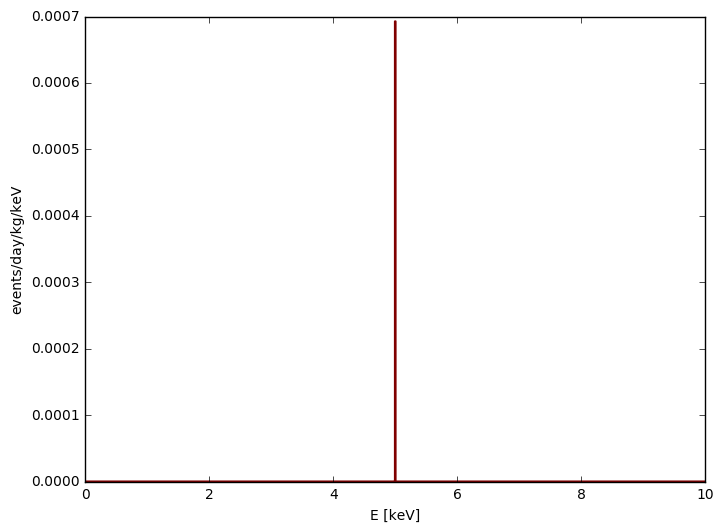

In [3]:
m = 5
g = 1e-13

alprate = ALP(m, g).rate() * 1000 * 365 # convert from events/kg/day to events/ton/yr
print('Rate: %0.2f' % alprate)
bins, rate = signal_model(m, g)
write_json(bins, rate, 'signal_models/ALP_%dkev.json' % m)


plt.figure()
plt.plot(np.linspace(*bins), rate, color='maroon', drawstyle='steps-mid')
plt.xlabel('E [keV]')
plt.ylabel('events/day/kg/keV')
plt.show()

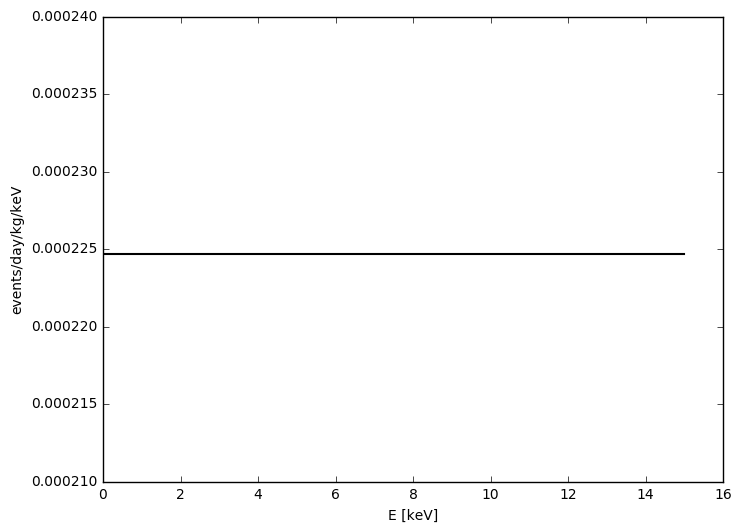

In [4]:
er_background = 82 # events/ton/yr/keV
er_background /= 1000*365 # events/kg/day/keV

bins, rate = flat_background_model(er_background)
write_json(bins, rate, 'signal_models/ER_background.json')

plt.figure()
plt.plot(np.linspace(*bins), rate, color='black')
plt.xlabel('E [keV]')
plt.ylabel('events/day/kg/keV')
plt.show()

[['cs1', [100, 0.0, 100.0]], ['log10_cs2', [125, 1.7, 3.9]]]


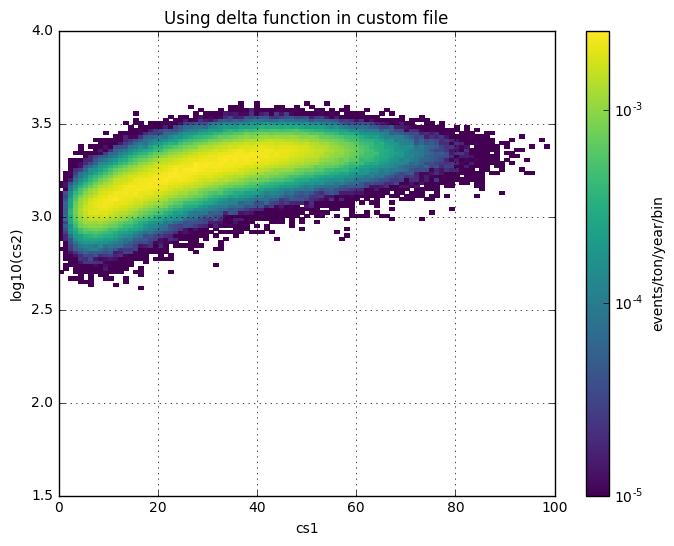

In [5]:
with open('/home/ershockley/axion_test.json') as f:
    data = json.load(f)
    
xbins, x0, x1 = data['binning'][0][1]
ybins, y0, y1 = data['binning'][1][1]
print(data['binning'])
hist = np.array(data['hist'])

x = np.linspace(x0, x1, xbins)
y = np.linspace(y0, y1, ybins)

colorscale = LogNorm(vmin=1e-5, vmax=hist.max())

hist = np.array(data['hist']).T
plt.pcolormesh(x, y, hist, norm=colorscale)
cbar = plt.colorbar()
cbar.set_label('events/ton/year/bin')
plt.grid()
plt.xlabel('cs1')
plt.ylabel('log10(cs2)')
plt.title('Using delta function in custom file')
plt.savefig('bbf_delta.pdf')
plt.show()

Total rate: 2.53e+02 events/ton/year


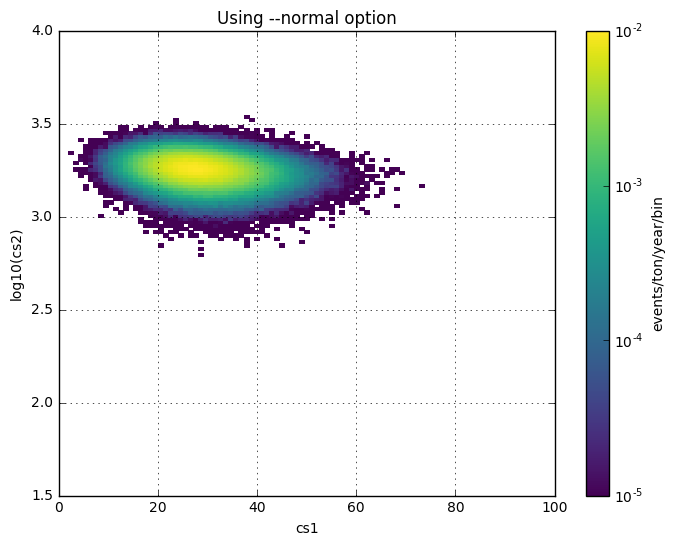

In [6]:
with open('/home/ershockley/axion_normaltest.json') as f:
    data = json.load(f)
    
xbins, x0, x1 = data['binning'][0][1]
ybins, y0, y1 = data['binning'][1][1]

hist = np.array(data['hist'])

hist = hist / hist.sum() * alprate

print('Total rate: %0.2e events/ton/year' % hist.sum())
x = np.linspace(x0, x1, xbins)
y = np.linspace(y0, y1, ybins)

colorscale = LogNorm(vmin=1e-5, vmax=1e-2)

hist = np.array(data['hist']).T
plt.pcolormesh(x, y, hist, norm=colorscale)
cbar = plt.colorbar()
cbar.set_label('events/ton/year/bin')
plt.grid()
plt.xlabel('cs1')
plt.ylabel('log10(cs2)')
plt.title('Using --normal option')
plt.savefig('bbf_normal.pdf')
plt.show()

## Solar Axion

In [7]:
def signal_model(m, g):
    A = SolarAxion(m, g)
    binning = [0.1, 10, 100]
    es = np.linspace(*binning)
    rates = A.dRdE(es)
    return binning, rates

Total rate: 961 events/ton/year


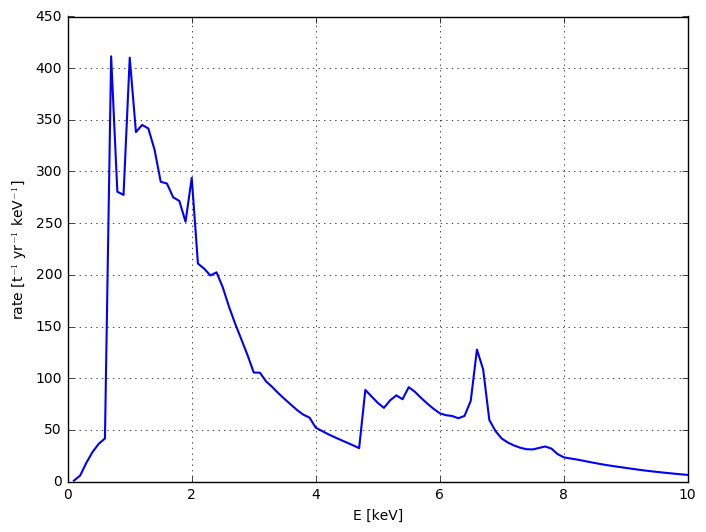

In [8]:
from scipy.integrate import simps

m = 1e-3 # keV
g = 5e-12

binning, rates = signal_model(m, g)
es = np.linspace(*binning)
integral = simps(rates, es)
print("Total rate: %d events/ton/year" % (integral * 365 * 1000))

write_json(binning, rates, 'signal_models/SolarAxion.json')

rates = rates * 1000 * 365 
f, ax = plt.subplots()
plt.plot(es, rates)
plt.xlabel('E [keV]')
plt.ylabel('rate [t$^{-1}$ yr$^{-1}$ keV$^{-1}$]')
plt.grid()
#plt.text(0.3, 0.8, "Total rate: %0.3g events/ton/year" % integral, transform=ax.transAxes)
plt.show()

Total events in bbf data: 572.4


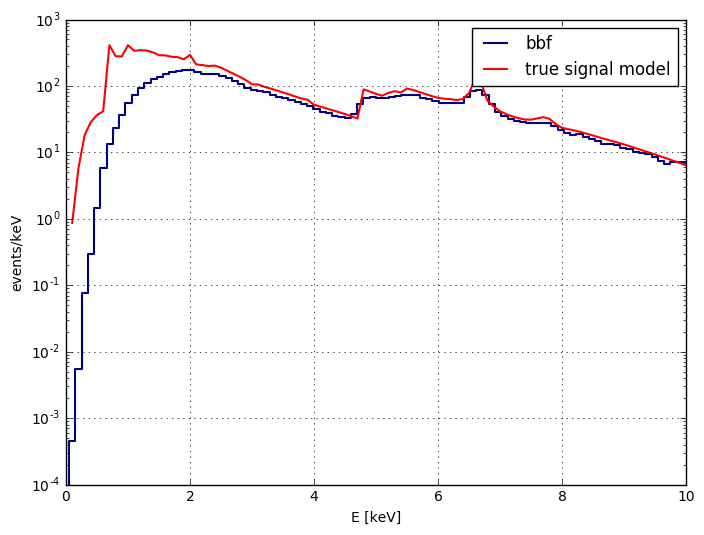

In [9]:
with open('/home/ershockley/solaraxion_Espectrum.json') as f:
    data = json.load(f)


xbins, x0, x1 = data['binning'][0][1]

hist = np.array(data['hist']) / (es[1]-es[0])

x = np.linspace(x0, x1, xbins)

data_integral = simps(hist, x)
print("Total events in bbf data: %0.4g" % data_integral)

plt.figure()
plt.plot(x, hist, drawstyle='steps-mid', color='navy', label='bbf')
plt.plot(es, rates, color='red', label='true signal model')
plt.xlabel('E [keV]')
plt.ylabel('events/keV')
plt.grid()
plt.yscale('log')
plt.legend()
plt.savefig('plots/compare_solar.png')
plt.show()

Total events: 567.28


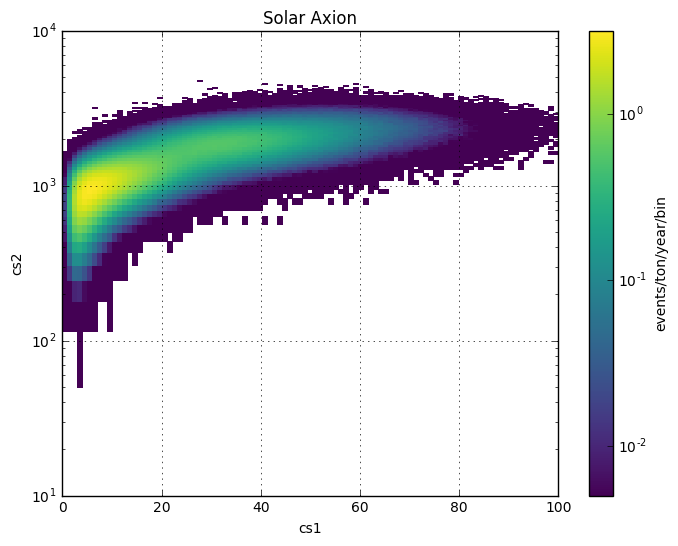

In [10]:
with open('/home/ershockley/solaraxion_cs1cs2.json') as f:
    data = json.load(f)
    
xbins, x0, x1 = data['binning'][0][1]
ybins, y0, y1 = data['binning'][1][1]

hist = np.array(data['hist'])

print("Total events: %0.2f" % hist.sum())
x = np.linspace(x0, x1, xbins)
y = np.linspace(y0, y1, ybins)

colorscale = LogNorm(vmin=5e-3, vmax=hist.max())

hist = np.array(data['hist']).T
plt.pcolormesh(x, y, hist, norm=colorscale)
cbar = plt.colorbar()
cbar.set_label('events/ton/year/bin')
plt.grid()
plt.xlabel('cs1')
plt.ylabel('cs2')
plt.yscale('log')
plt.title('Solar Axion')
plt.show()

870.784126023


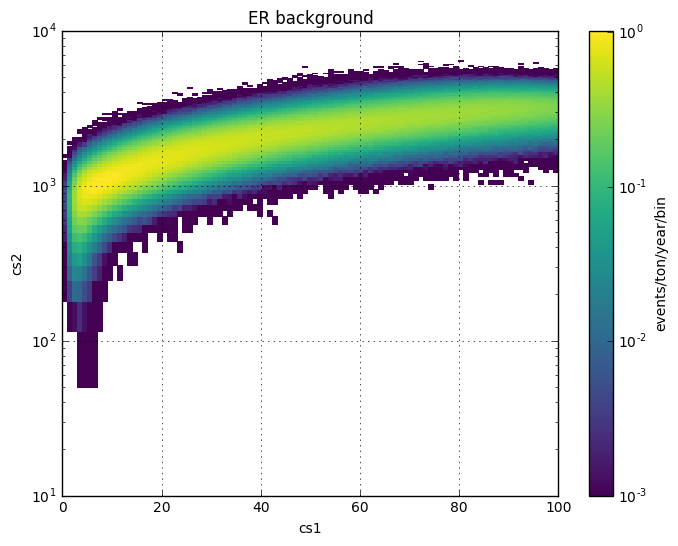

In [11]:
with open('/home/ershockley/er_cs1cs2.json') as f:
    data = json.load(f)
    
xbins, x0, x1 = data['binning'][0][1]
ybins, y0, y1 = data['binning'][1][1]

hist = np.array(data['hist'])
print(hist.sum())
x = np.linspace(x0, x1, xbins)
y = np.linspace(y0, y1, ybins)

colorscale = LogNorm(vmin=1e-3, vmax=hist.max())

hist = np.array(data['hist']).T
plt.pcolormesh(x, y, hist, norm=colorscale)
cbar = plt.colorbar()
cbar.set_label('events/ton/year/bin')
plt.grid()
plt.xlabel('cs1')
plt.ylabel('cs2')
plt.yscale('log')
plt.title('ER background')
plt.show()

In [12]:
newdata = {}

with open('/home/ershockley/bbf/data/ERBand_SR1.json') as f:
    data = json.load(f)
    
    
newdata['binning'] = data['coordinate_system']
for i, info in enumerate(newdata['binning']):
    label = info[0]
    nbins = info[1][2]
    rng1, rng2 = info[1][:2]
    newdata['binning'][i] = [label, [nbins, rng1, rng2]]
    
newdata['hist'] = data['map']

#with open('/home/ershockley/analysis/axions/ERband.json', 'w') as f:
#    json.dump(newdata, f)

In [45]:
from laidbax.base_model import config
from bbfsource import BBFSource

myconfig = config.copy()

myconfig['force_recalculation'] = True
myconfig['never_save_to_cache'] = True
myconfig['data_dirs'] = ['.', '/home/ershockley/analysis/axions/data']

myconfig['analysis_space'] = (('cs1', tuple(np.linspace(0, 100, 101))),
                              #('cs2', tuple(np.linspace(200, 5000, 100))))
                              ('cs2_bottom', tuple(np.linspace(500, 8000, 126))))
#myconfig['analysis_space'] = (('cs1', tuple(np.linspace(3, 70, 68))),
#                              ('cs2', tuple(np.logspace(*np.log10([50, 8000]), num=71)))),

# this was changed in laidbax, but model doesn't match data with new change
# TODO need to figure this out

myconfig['livetime_days'] = 246.7
myconfig['fiducial_mass'] = 1042
myconfig['default_source_class'] = BBFSource

In [46]:
import multihist as mh
def json_to_multihist(jsonname):
    """Converts a json output from bbf to a multihist object"""
    if not os.path.exists(jsonname):
        raise FileNotFoundError

    with open(jsonname) as f:
        data = json.load(f)

    # check dimension
    
    axis_names = [data['binning'][0][0], data['binning'][1][0]]

    xbins, x0, x1 = data['binning'][0][1]
    ybins, y0, y1 = data['binning'][1][1]

    x_edges = np.linspace(x0, x1, xbins)
    y_edges = np.linspace(y0, y1, ybins)

    hist = np.array(data['hist'])

    out_hist = mh.Histdd.from_histogram(hist, axis_names=axis_names, bin_edges=[x_edges, y_edges])
    return out_hist

In [1]:

er_ignore_parameters = ['nr_gamma', 'nr_alpha', 'nr_lambda', 'nr_ee', 'wimp_mass', 'nr_eta', 'efficiency']

er_config = {'color': 'blue',
             'jsonname': '/home/ershockley/er_cs1cs2.json',
             'extra_dont_hash_settings': er_ignore_parameters,
             'label': 'ER',
             'n_events_for_pdf': 20000000.0,
             'name': 'er',
             'recoil_type': 'er',
             'in_events_per_bin': True}

solar_config = {'color': 'red',
                'jsonname': '/home/ershockley/solaraxion_cs1cs2.json',
                'extra_dont_hash_settings': er_ignore_parameters,
                'label': 'solar axion',
                'n_events_for_pdf': 20000000.0,
                'name': 'solar_axion',
                'recoil_type': 'er',
                'in_events_per_bin': True}

myconfig['sources'] = [er_config, solar_config]


NameError: name 'myconfig' is not defined

In [48]:
lf = bi.UnbinnedLogLikelihood(myconfig)
lf.add_rate_parameter('er')
lf.add_rate_parameter('solar_axion')
lf.prepare()

Opening /home/ershockley/er_cs1cs2.json
Opening /home/ershockley/solaraxion_cs1cs2.json


In [49]:
d = lf.base_model.simulate(dict(solar_axion=1, er=1))
print("Total events: %d" % len(d))
lf.set_data(d)

Total events: 1021


Total events: 984


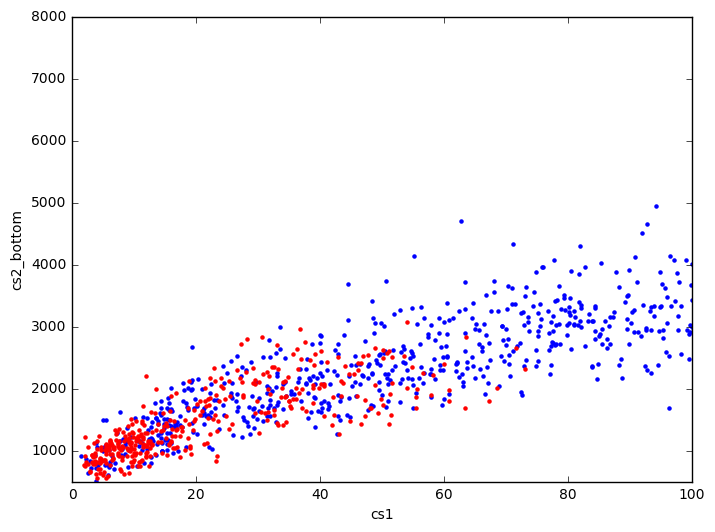

In [50]:
d = lf.base_model.simulate(dict(solar_axion=1, er=1))
print("Total events: %d" % len(d))
lf.set_data(d)

lf.base_model.show(d)
plt.show()

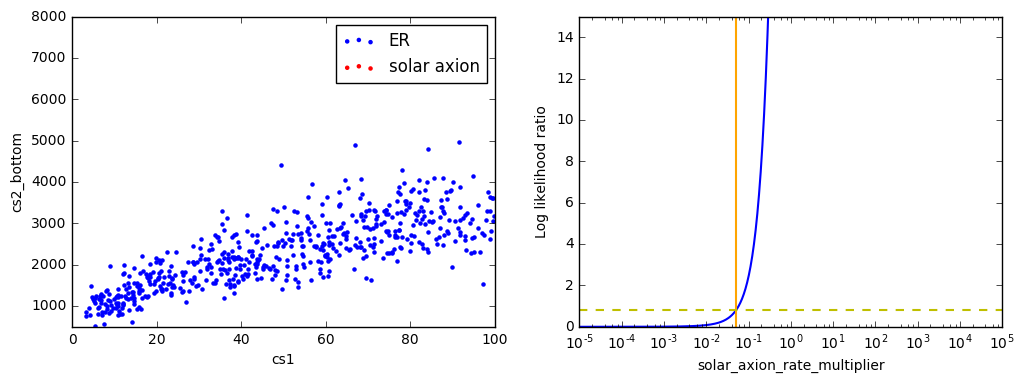

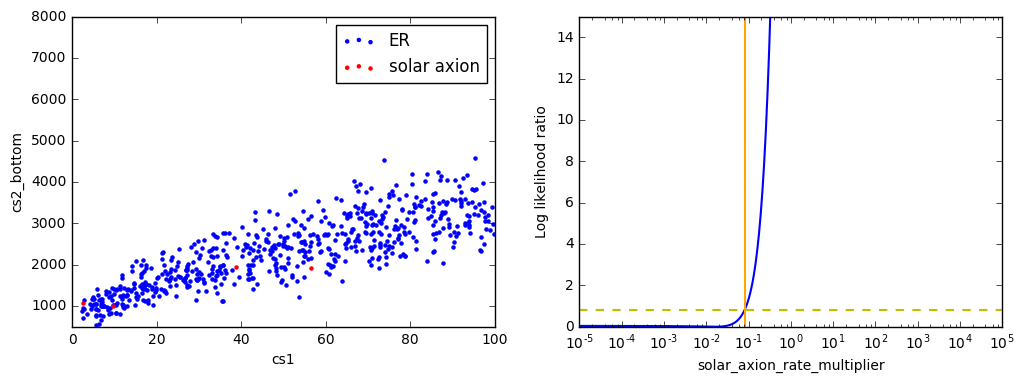

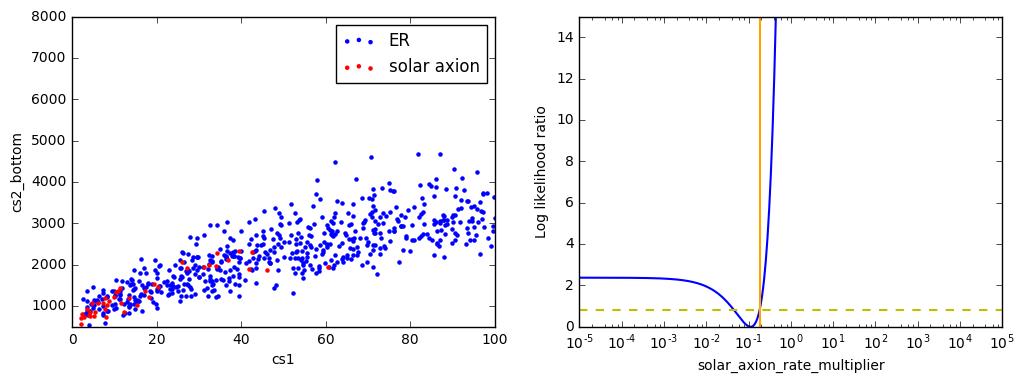

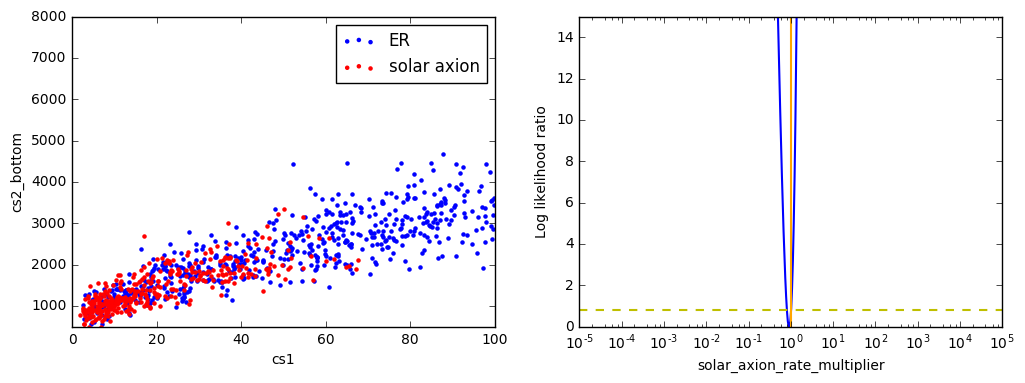

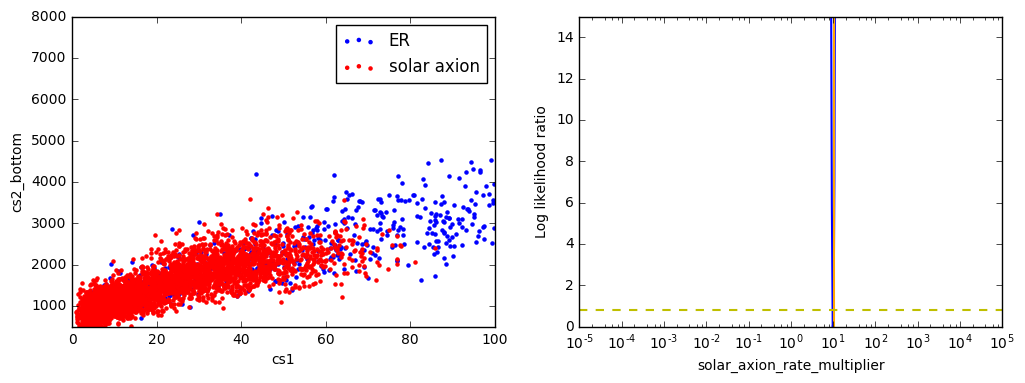

In [51]:
from blueice.inference import bestfit_scipy
from scipy import stats


minimize_kwargs = {'method' : "Powell", "options" : {'maxiter' : 10000000}}
space_axion = ('solar_axion_rate_multiplier', np.logspace(-5, 5, 500))

rate_mults = [0, 1e-2, 1e-1, 1, 1e1]
for rm in rate_mults:
    d = lf.base_model.simulate(dict(solar_axion=rm, er=1))
    #fit_result, max_ll = bi.inference.bestfit_scipy(lf, minimize_kwargs=minimize_kwargs)
    lf.set_data(d)
    
    limit = bi.inference.one_parameter_interval(lf, 'solar_axion_rate_multiplier', 1e4,
                                                bestfit_routine=bestfit_scipy,
                                                minimize_kwargs=minimize_kwargs)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.sca(ax1)
    lf.base_model.show(d)
    plt.legend()
    
    plt.sca(ax2)
    bi.inference.plot_likelihood_ratio(lf, space_axion, bestfit_routine=bestfit_scipy,
                                                     minimize_kwargs=minimize_kwargs) 
    plt.axvline(limit, color='orange')
    plt.axhline(stats.norm.ppf(0.9)**2/2,
            label='Asymptotic limit', color='y', linestyle='--')
    plt.xscale('log')
    plt.show()

In [32]:
import pandas as pd
# read in data
datadir = '/home/ershockley/analysis/axions/data'

sr1 = pd.read_hdf(os.path.join(datadir,'none_SR1_pax6.8.0_hax2.4.0_lax1.5.1_cs1LT200_fv1_cuts1.h5'), 'table')

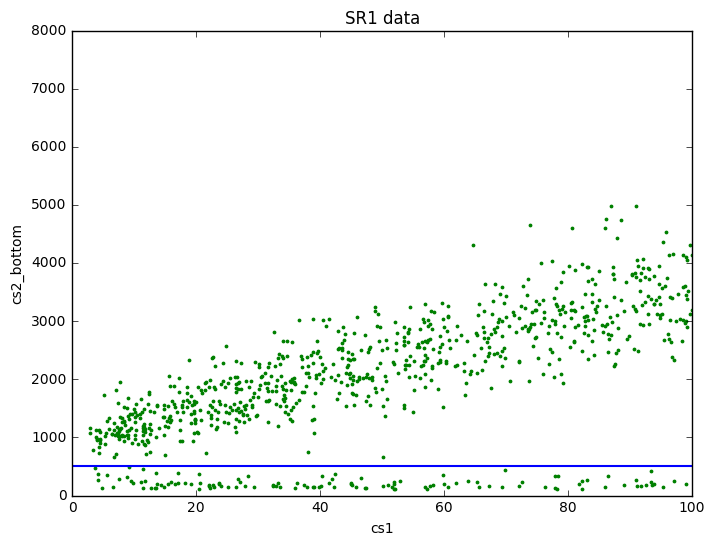

In [52]:
plt.scatter(sr1['cs1'], sr1['cs2_bottom'], color='green', s=3)
plt.xlim(0, 100)
plt.ylim(0, 8000)
plt.xlabel('cs1')
plt.ylabel('cs2_bottom')
plt.title('SR1 data')
plt.axhline(500)
plt.show()

In [53]:
sr1 = sr1[sr1['cs2_bottom'] > 500]

lf.set_data(sr1)

In [55]:
limit = bi.inference.one_parameter_interval(lf, 'solar_axion_rate_multiplier', 1e4,
                                        bestfit_routine=bestfit_scipy,
                                        minimize_kwargs=minimize_kwargs)
print(5e-12 * limit**0.25)

1.3514687178446508e-12


In [59]:
x = np.linspace(0, 10, 10)
len(x), max(x), min(x)

(10, 10.0, 0.0)